# 1. Постановка задачи

## 1.1. Постановка задачи

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## 1.2. Описание данных

- datetime - время 
- num-orders - количество заказов

# 2. Импорт данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.core.display import display, HTML
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

C:\Users\usach\AppData\Local\Temp\ipykernel_2244\3256573903.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
def read_data_set(pth1, pth2) -> pd.DataFrame:
    df = pd.DataFrame    
    try:
        df = pd.read_csv(pth1, parse_dates= ['datetime'], index_col= 'datetime')
    except OSError as e:
        df = pd.read_csv(pth2, parse_dates= ['datetime'], index_col= 'datetime')
    return df

In [4]:
pth1 = 'datasets/taxi.csv'         
pth2 = 'https://code.s3.yandex.net/datasets/taxi.csv'
df = read_data_set(pth1, pth2);

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.sample(10)

num_orders
datetime                       
2018-06-27 02:30:00          10
2018-05-11 21:00:00          20
2018-08-14 07:30:00          10
2018-04-03 12:20:00           4
2018-05-14 03:00:00          16
2018-07-20 19:20:00           8
2018-04-14 00:40:00          25
2018-07-16 12:40:00          12
2018-07-26 15:20:00          15
2018-08-18 17:10:00          18

Пропуски/явные дубликаты

In [7]:
df.isna().sum()

num_orders    0
dtype: int64

In [8]:
df.index.duplicated().sum()

0

Пропусков/явных дубликатов нет

Посмотрим выбросы

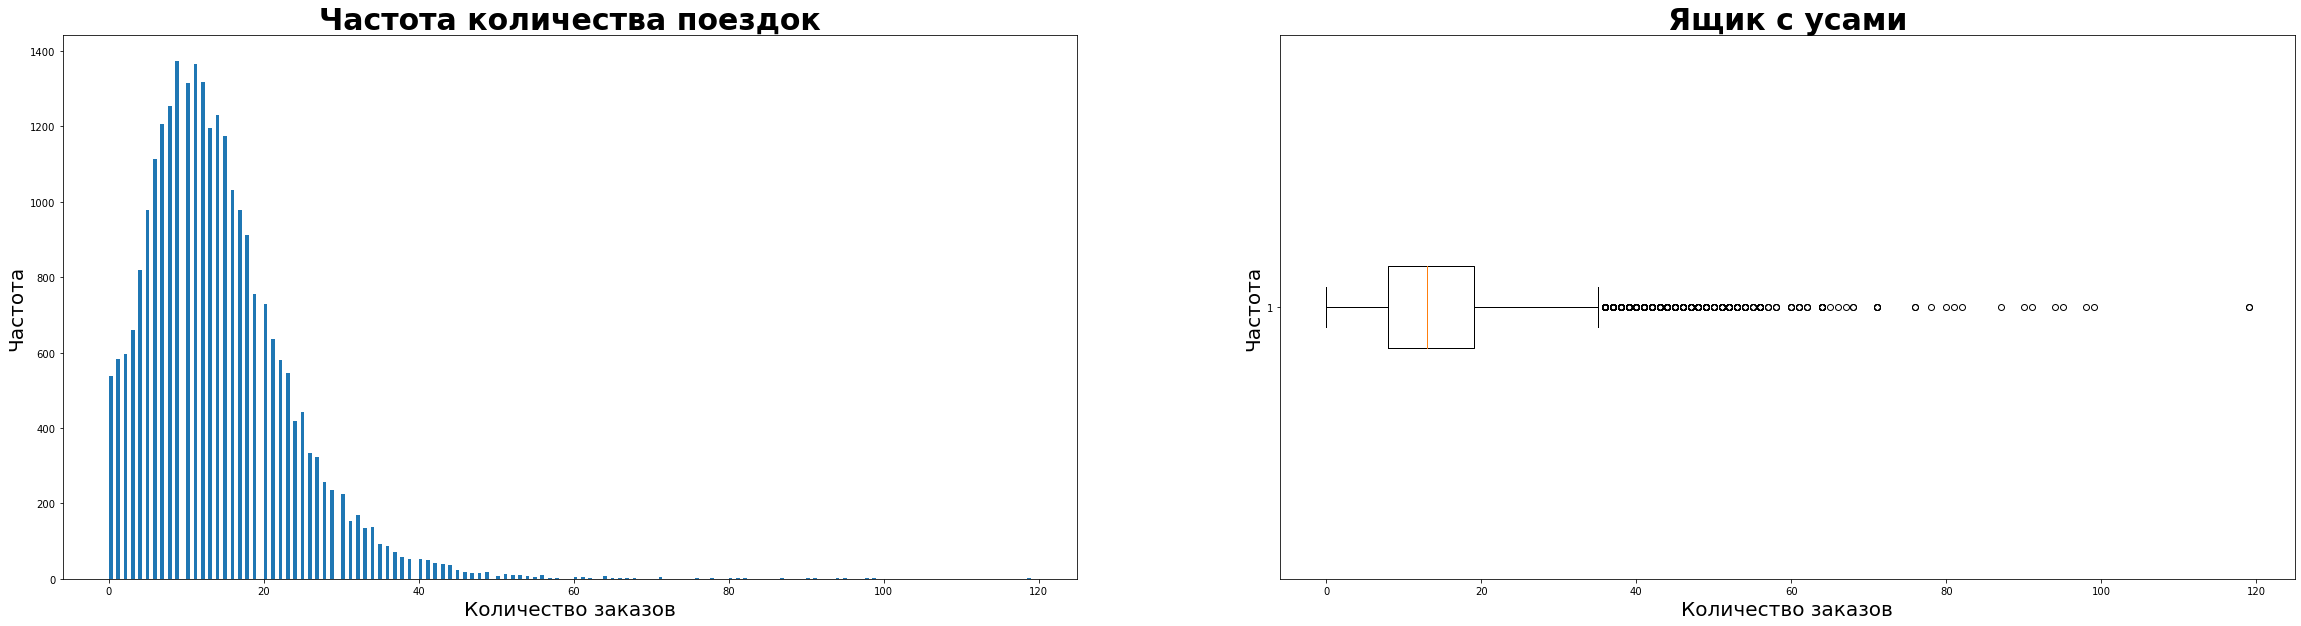

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(40,10))
axs[0].title.set_text('Частота количества поездок')
axs[1].title.set_text('Ящик с усами')
axs[0].title.set_fontweight('bold')
axs[1].title.set_fontweight('bold')
axs[0].title.set_size(30)
axs[1].title.set_size(30)
axs[0].set_xlabel('Количество заказов', fontsize = 20.0)
axs[0].set_ylabel('Частота', fontsize = 20.0)
axs[1].set_xlabel('Количество заказов', fontsize = 20.0)
axs[1].set_ylabel('Частота', fontsize = 20.0)
axs[0].hist(df, bins=250);
axs[1].boxplot(df, vert= False);

In [10]:
float(df[df.num_orders > 40].count()/df.count()*100)

1.385114734299517

Уберем знаечния > 40 заказов в час

In [12]:
df.shape[0]

26496

Подготовим данные за каждый час

In [13]:
df.sort_index(inplace=True)

In [14]:
df = df.resample('1H').sum()
df_d = df.copy()

In [15]:
df.sample(10)

num_orders
datetime                       
2018-06-17 02:00:00          83
2018-08-21 04:00:00         216
2018-08-24 09:00:00         170
2018-05-12 04:00:00          41
2018-06-29 03:00:00          91
2018-06-26 19:00:00          82
2018-07-11 00:00:00         172
2018-03-18 14:00:00          55
2018-05-14 18:00:00          52
2018-05-29 19:00:00          57

In [16]:
df.shape[0]

4416

In [17]:
def plot_df(df:pd.DataFrame()):
    plt.figure(figsize=(25, 25))
    df['mean'] = df['num_orders'].rolling(15).mean()
    df['std'] = df['num_orders'].rolling(15).std()
    df.plot(ax=plt.gca());
    return

In [18]:
def decompose_df(df:pd.DataFrame):
    decomposed = seasonal_decompose(df['num_orders']) 
    plt.figure(figsize=(25, 10))
    plt.subplot(311)
    plt.title('Тренды')
    decomposed.trend.plot(ax=plt.gca());
    plt.subplot(312)
    plt.title('Сезонность')
    decomposed.seasonal.plot(ax=plt.gca());
    plt.subplot(313)    
    plt.title('Шум')
    decomposed.resid.plot(ax=plt.gca());
    return

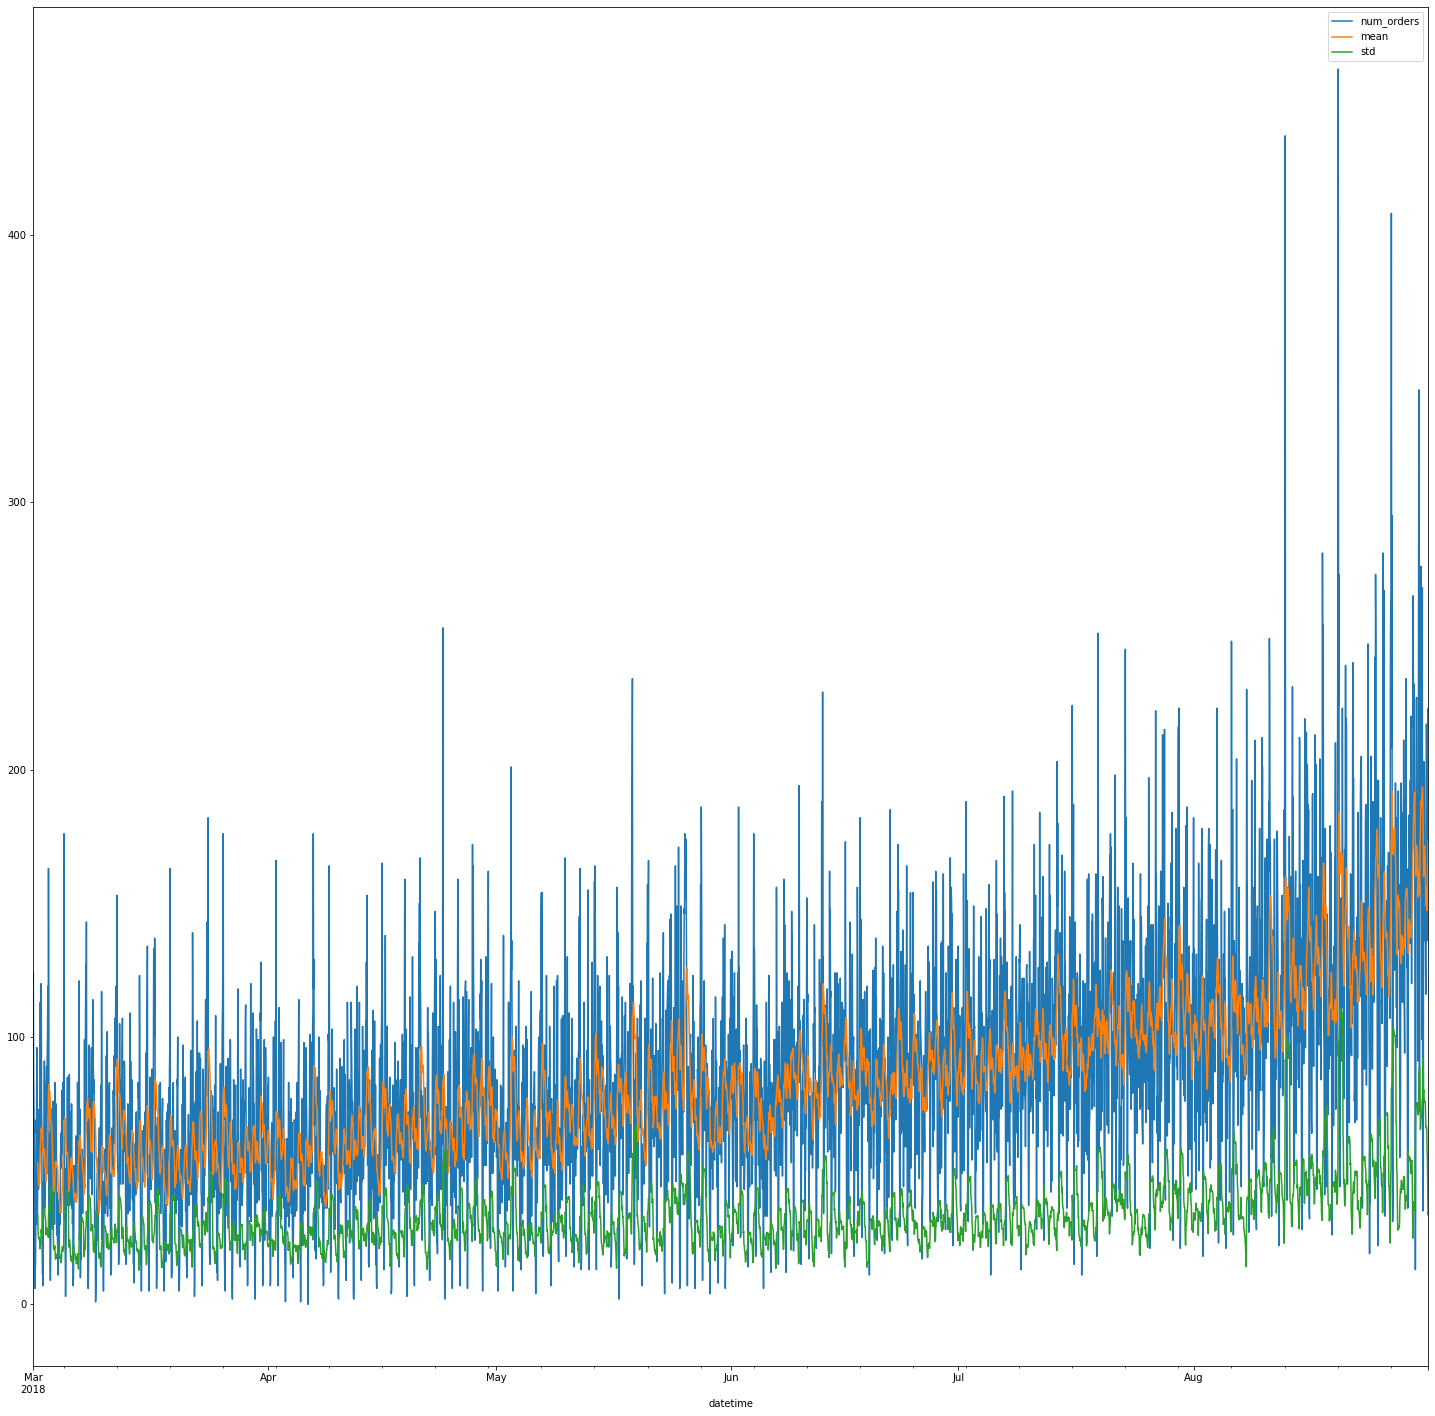

In [19]:
plot_df(df);

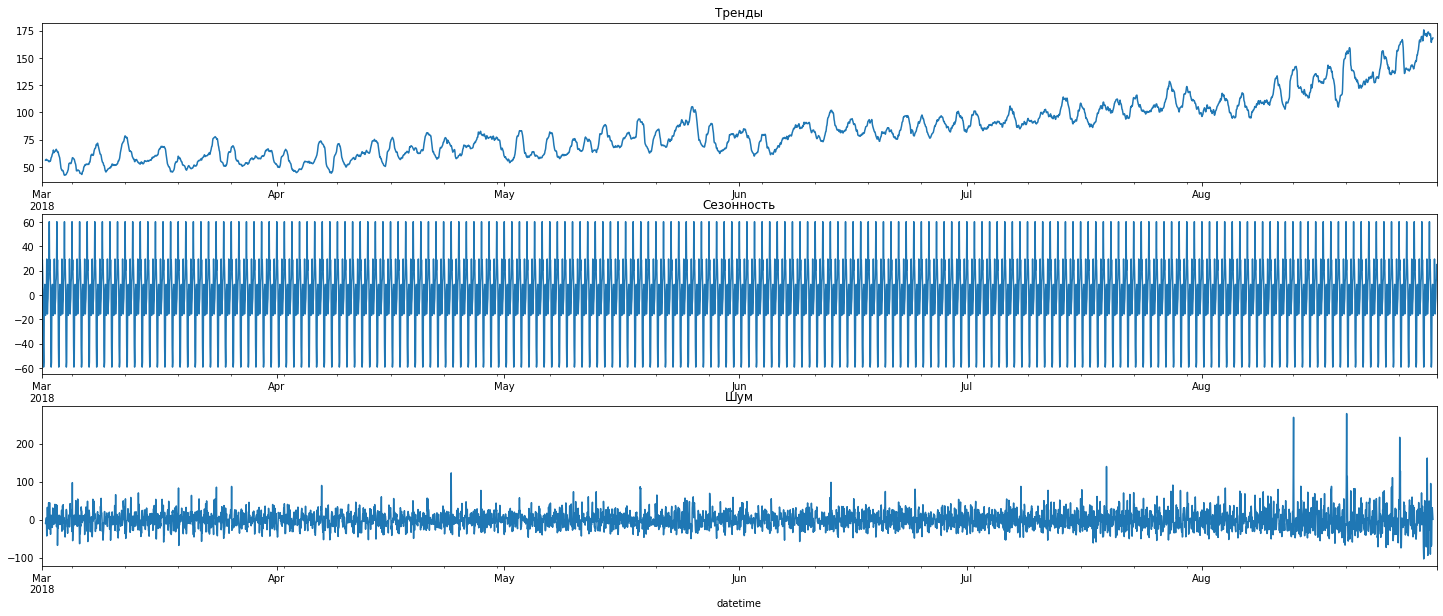

In [20]:
decompose_df(df)

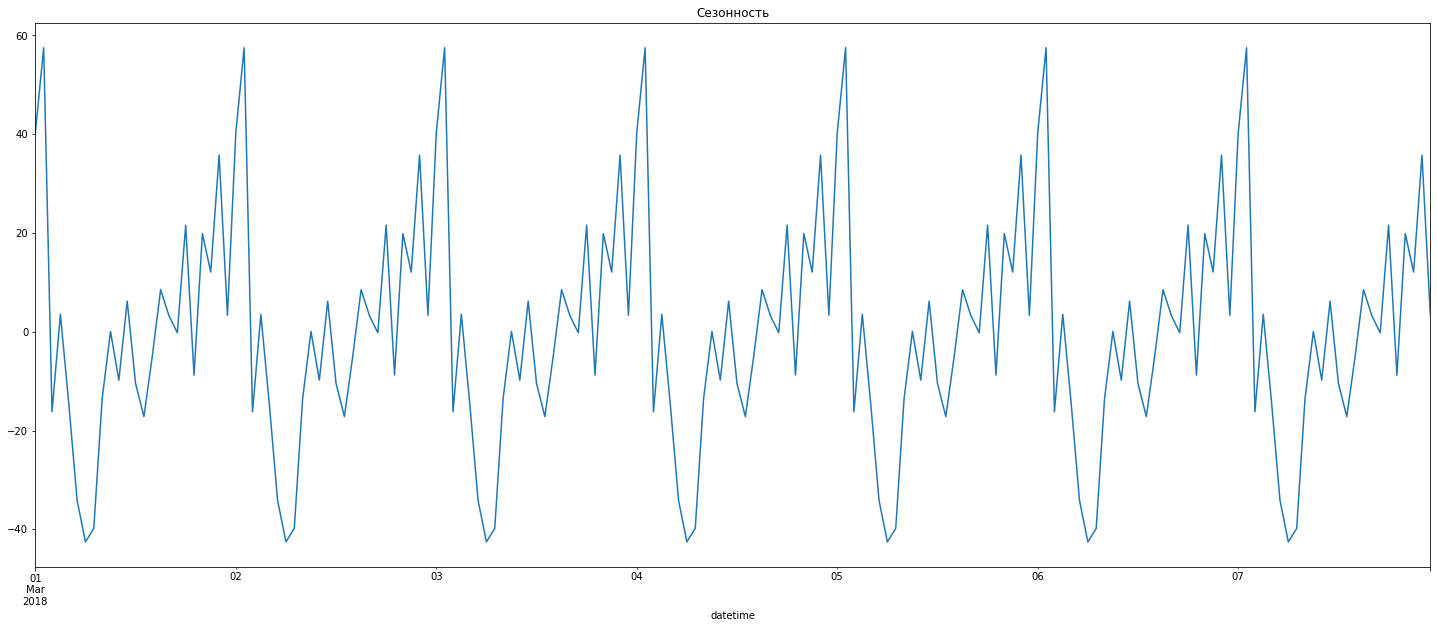

In [21]:
df_zoom = df['2018-03-01':'2018-03-7']
decomposed = seasonal_decompose(df_zoom['num_orders']) 
plt.figure(figsize=(25,10))
plt.title('Сезонность')
decomposed.seasonal.plot();

Временной ряд нестационарный. Сделаем его стационарным

In [22]:
df.shape[0]

4416

In [23]:
df -= df.shift()
df = df.dropna()
df.sort_index(inplace=True)

In [24]:
df.shape[0]

4401

C:\Users\usach\AppData\Local\Temp\ipykernel_2244\2985429648.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean'] = df['num_orders'].rolling(15).mean()
C:\Users\usach\AppData\Local\Temp\ipykernel_2244\2985429648.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std'] = df['num_orders'].rolling(15).std()


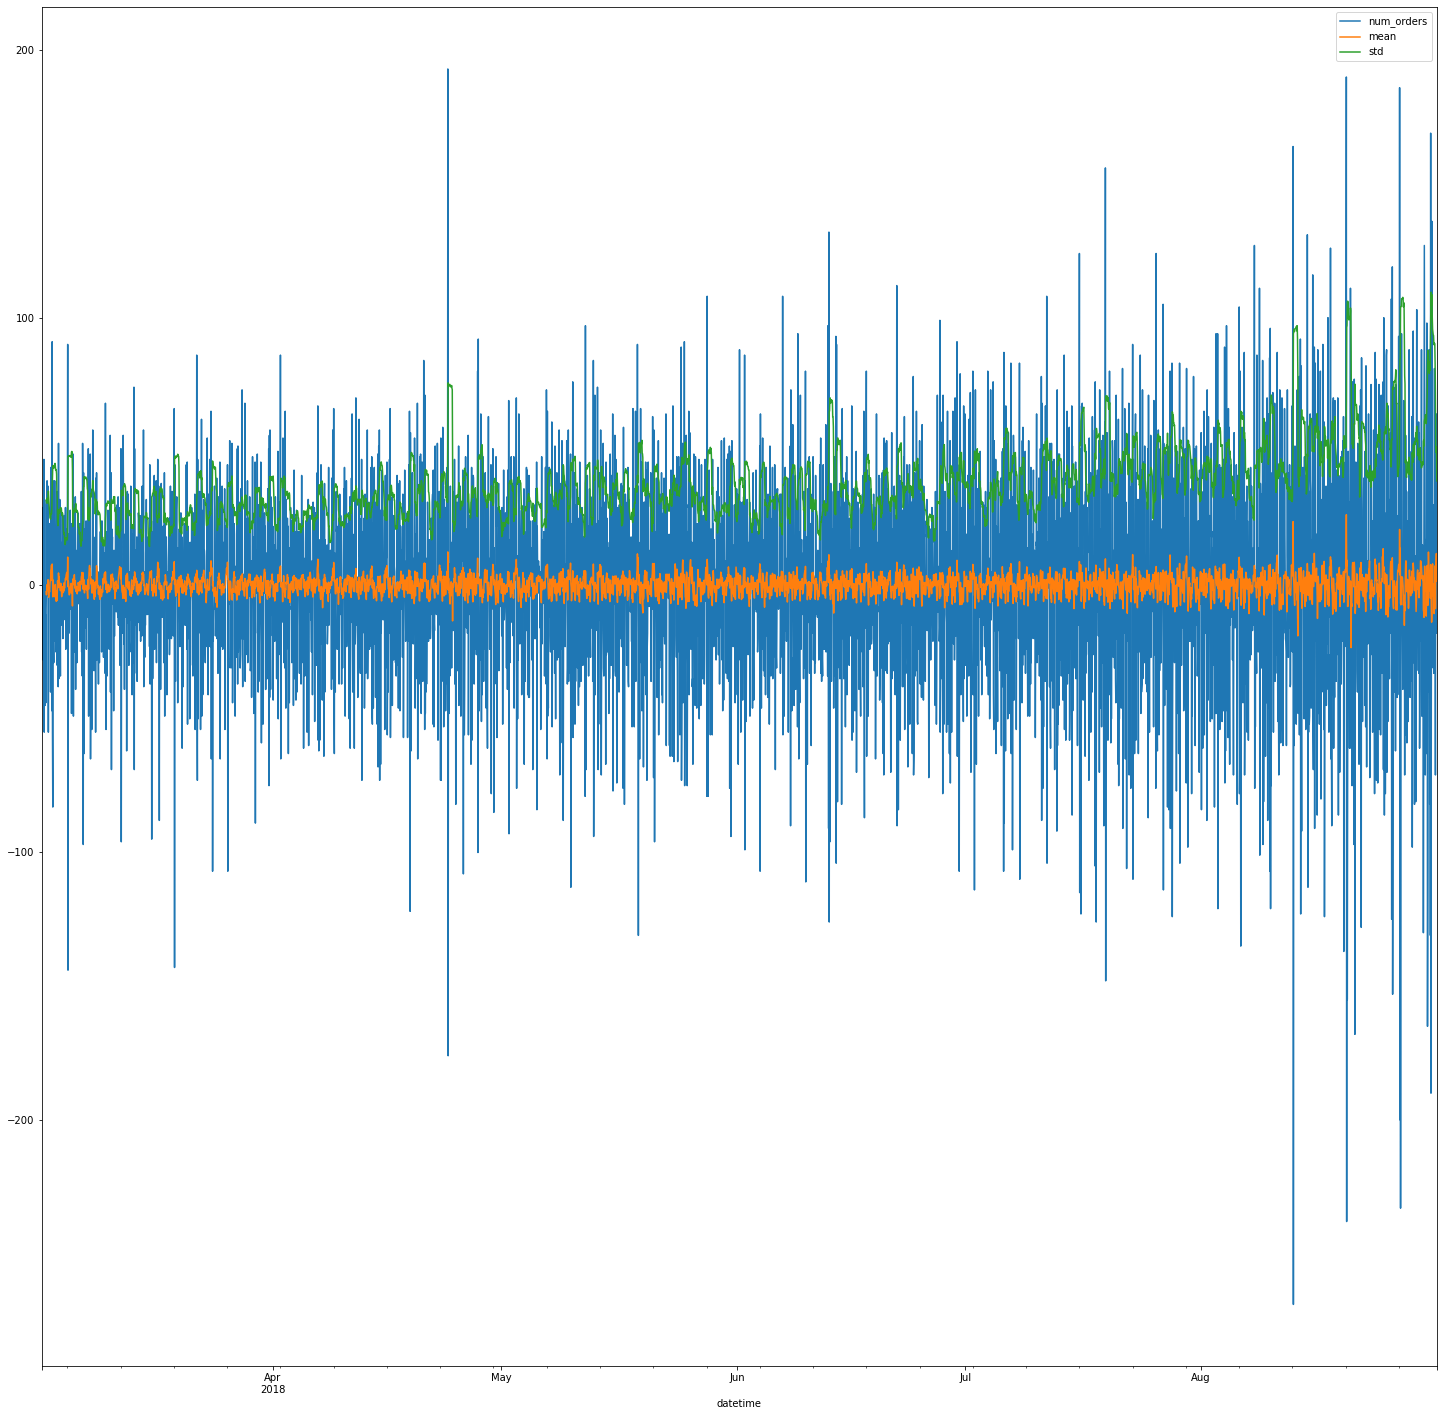

In [25]:
plot_df(df)

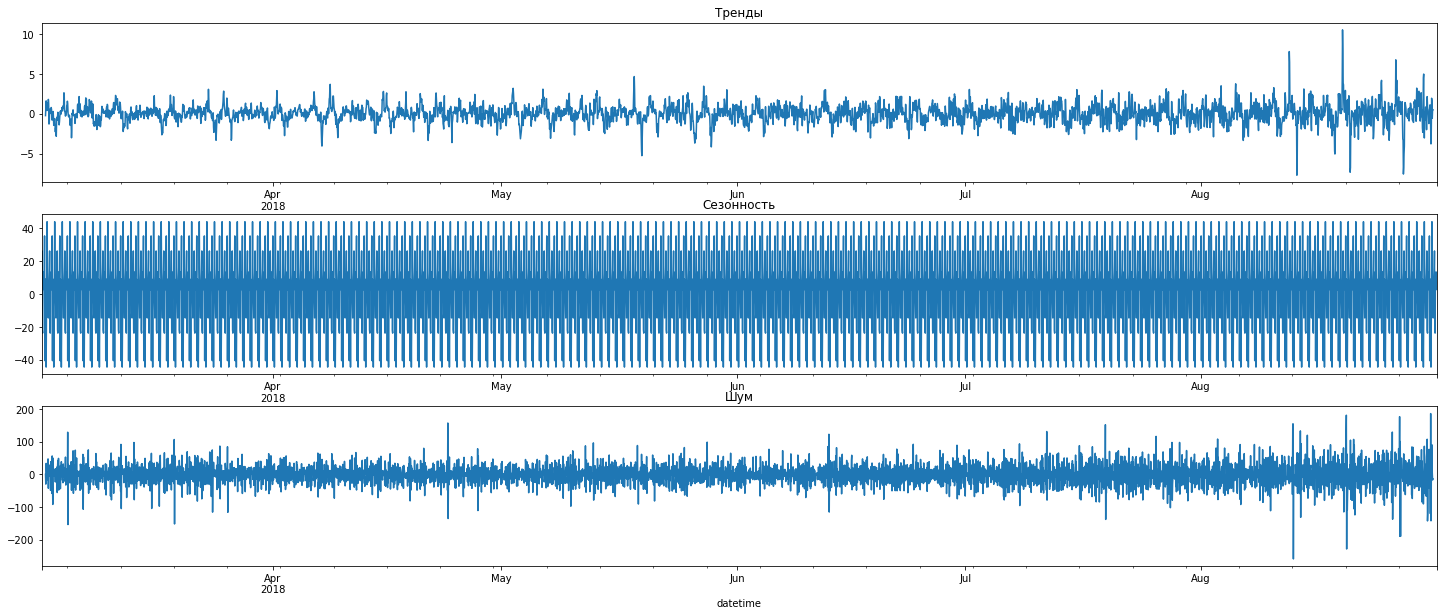

In [26]:
decompose_df(df)

**Выводы:**

1. В датасете пропусков и явных дубликатов не обнаружено.
2. Представленн нестационарный ряд, по которому делать предсказания сложно 

В ходе этапа:
    
1. Ресемплировали ряд под 1 час, так как требуется предсказывать именно такой интервал 
2. Сделали ряд стационарным

Судя по трендам, количество заказов растет от начала года к концу. Количество заказов в течение дня также имеет схожую динамику каждый день (сезонность)

Теперь можно приступать к формированию выборок

C:\Users\usach\AppData\Local\Temp\ipykernel_2244\2985429648.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean'] = df['num_orders'].rolling(15).mean()
C:\Users\usach\AppData\Local\Temp\ipykernel_2244\2985429648.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std'] = df['num_orders'].rolling(15).std()


Text(0, 0.5, 'Количество заказов')

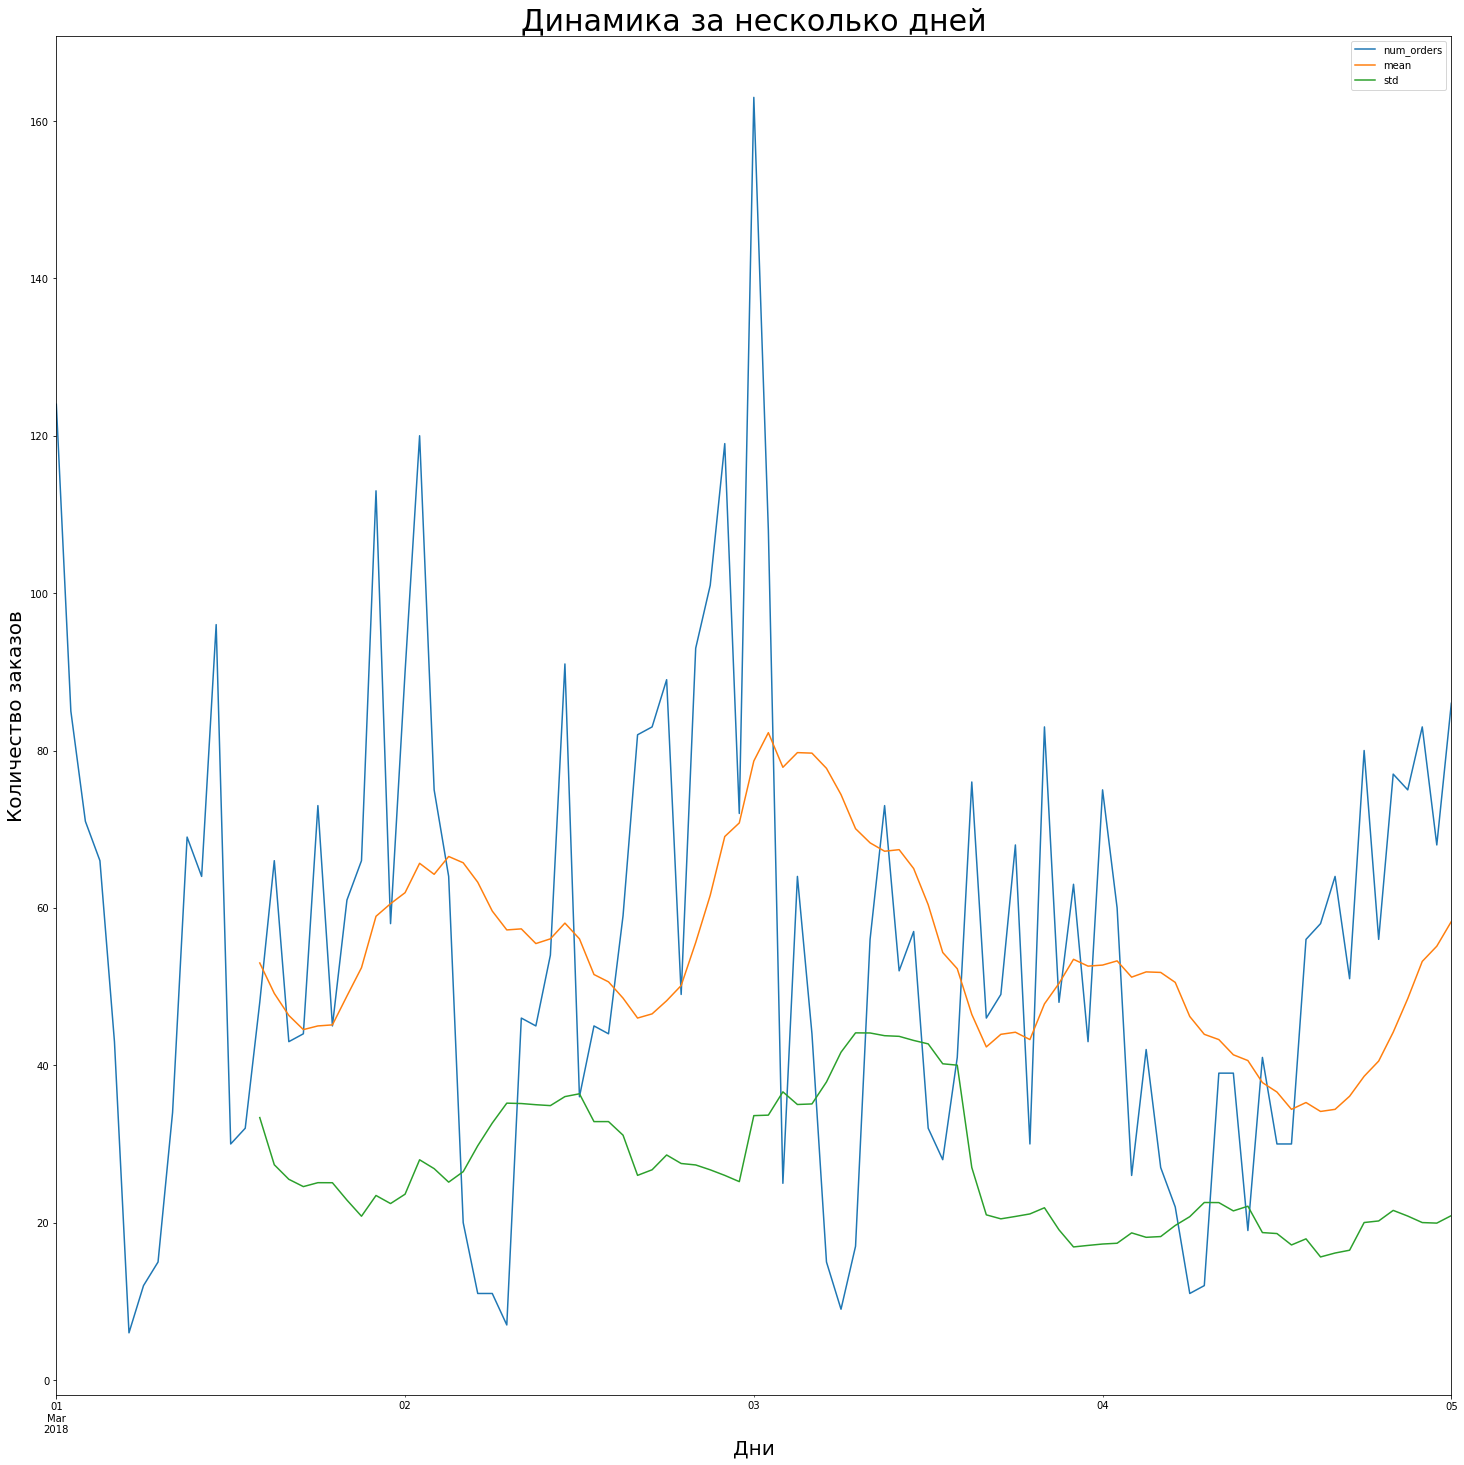

In [27]:
plot_df(df_d['2018-03-01 00:00:00' : '2018-03-05 00:00:00'])
plt.title('Динамика за несколько дней', fontsize = 30.0)
plt.xlabel('Дни', fontsize = 20.0)
plt.ylabel('Количество заказов', fontsize = 20.0)

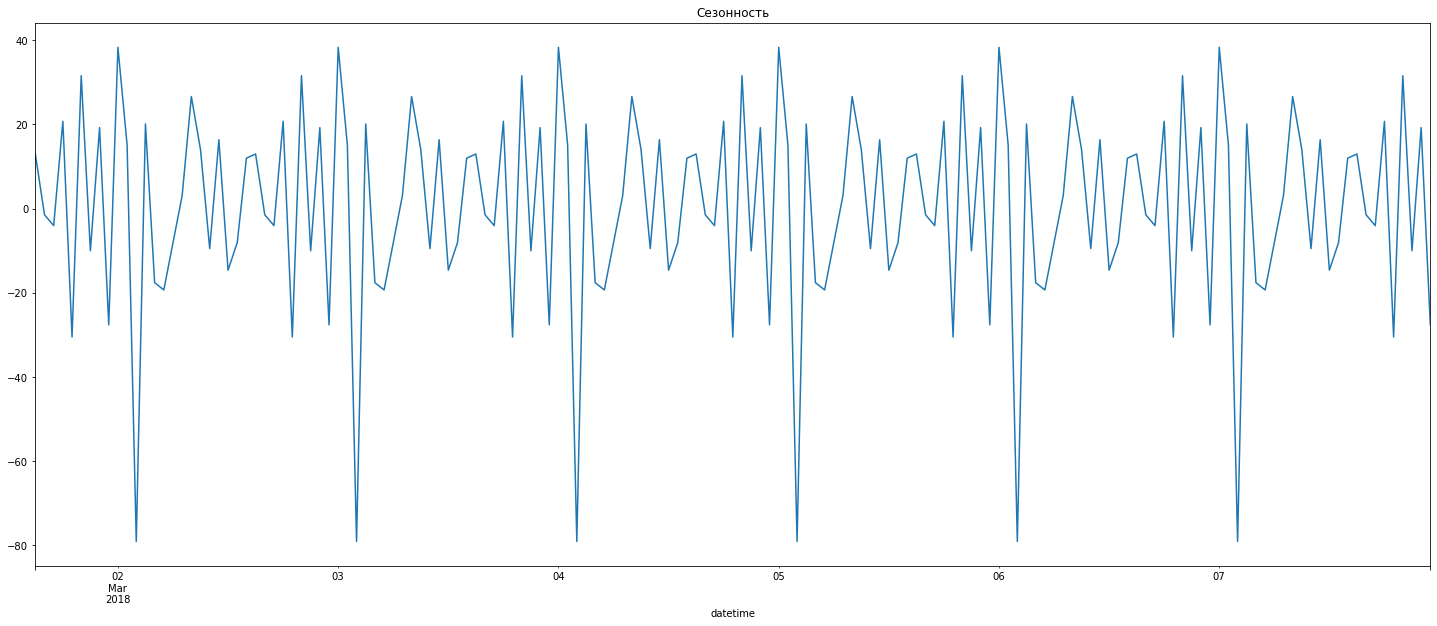

In [28]:
df_zoom = df['2018-03-01':'2018-03-7']
decomposed = seasonal_decompose(df_zoom['num_orders']) 
plt.figure(figsize=(25,10))
plt.title('Сезонность')
decomposed.seasonal.plot();

# 3. Формирование выборок и построение модели

# 3.1 Подготовка признаков

In [29]:
df.index.year.unique()

Int64Index([2018], dtype='int64', name='datetime')

In [30]:
def make_features(df:pd.DataFrame, max_lag:int, rolling_mean_size:int) -> pd.DataFrame:   
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [31]:
pd.options.mode.chained_assignment = None
make_features(df, 100, 100)

C:\Users\usach\AppData\Local\Temp\ipykernel_2244\741976297.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
C:\Users\usach\AppData\Local\Temp\ipykernel_2244\741976297.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
C:\Users\usach\AppData\Local\Temp\ipykernel_2244\741976297.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

num_orders       mean        std  month  day  dayofweek  \
datetime                                                                       
2018-03-01 15:00:00        18.0        NaN        NaN      3    1          3   
2018-03-01 16:00:00       -23.0        NaN        NaN      3    1          3   
2018-03-01 17:00:00         1.0        NaN        NaN      3    1          3   
2018-03-01 18:00:00        29.0        NaN        NaN      3    1          3   
2018-03-01 19:00:00       -28.0        NaN        NaN      3    1          3   
...                         ...        ...        ...    ...  ...        ...   
2018-08-31 19:00:00       -71.0  -8.800000  71.667087      8   31          4   
2018-08-31 20:00:00        18.0   5.066667  51.344031      8   31          4   
2018-08-31 21:00:00         5.0   8.266667  49.600499      8   31          4   
2018-08-31 22:00:00        64.0  11.800000  51.654346      8   31          4   
2018-08-31 23:00:00       -18.0   1.533333  38.946606      8   31          4   

                     lag_1  lag_2  lag_3  lag_4  ...  lag_92  lag_93  lag_94  \
datetime                                         ...                           
2018-03-01 15:00:00    NaN    NaN    NaN    NaN  ...     NaN     NaN     NaN   
2018-03-01 16:00:00   18.0    NaN    NaN    NaN  ...     NaN     NaN     NaN   
2018-03-01 17:00:00  -23.0   18.0    NaN    NaN  ...     NaN     NaN     NaN   
2018-03-01 18:00:00    1.0  -23.0   18.0    NaN  ...     NaN     NaN     NaN   
2018-03-01 19:00:00   29.0    1.0  -23.0   18.0  ...     NaN     NaN     NaN   
...                    ...    ...    ...    ...  ...     ...     ...     ...   
2018-08-31 19:00:00  -10.0   20.0   81.0  -17.0  ...   -16.0    21.0    56.0   
2018-08-31 20:00:00  -71.0  -10.0   20.0   81.0  ...    35.0   -16.0    21.0   
2018-08-31 21:00:00   18.0  -71.0  -10.0   20.0  ...   -59.0    35.0   -16.0   
2018-08-31 22:00:00    5.0   18.0  -71.0  -10.0  ...     0.0   -59.0    35.0   
2018-08-31 23:00:00   64.0    5.0   18.0  -71.0  ...    24.0     0.0   -59.0   

                     lag_95  lag_96  lag_97  lag_98  lag_99  lag_100  \
datetime                                                               
2018-03-01 15:00:00     NaN     NaN     NaN     NaN     NaN      NaN   
2018-03-01 16:00:00     NaN     NaN     NaN     NaN     NaN      NaN   
2018-03-01 17:00:00     NaN     NaN     NaN     NaN     NaN      NaN   
2018-03-01 18:00:00     NaN     NaN     NaN     NaN     NaN      NaN   
2018-03-01 19:00:00     NaN     NaN     NaN     NaN     NaN      NaN   
...                     ...     ...     ...     ...     ...      ...   
2018-08-31 19:00:00   -56.0    41.0   -71.0    17.0   -30.0     69.0   
2018-08-31 20:00:00    56.0   -56.0    41.0   -71.0    17.0    -30.0   
2018-08-31 21:00:00    21.0    56.0   -56.0    41.0   -71.0     17.0   
2018-08-31 22:00:00   -16.0    21.0    56.0   -56.0    41.0    -71.0   
2018-08-31 23:00:00    35.0   -16.0    21.0    56.0   -56.0     41.0   

                     rolling_mean  
datetime                           
2018-03-01 15:00:00           NaN  
2018-03-01 16:00:00           NaN  
2018-03-01 17:00:00           NaN  
2018-03-01 18:00:00           NaN  
2018-03-01 19:00:00           NaN  
...                           ...  
2018-08-31 19:00:00          0.81  
2018-08-31 20:00:00         -0.59  
2018-08-31 21:00:00         -0.11  
2018-08-31 22:00:00         -0.23  
2018-08-31 23:00:00          1.12  

[4401 rows x 107 columns]

In [32]:
df.corr().style.background_gradient(cmap='coolwarm')

Признаки mean и std не нужны.

In [33]:
df = df.drop(columns= ['mean', 'std'])

**Вывод:**

В ходе данного этапа были подготовлены признаки для дальнейшего объединения в выборки.
В числе признаков были выделены: 

    - категориальные: day, month, dayofweek
    - отстающие значения: lag... (нужны для определения возрастания/убывания функции)
    - скользящее среднее: rolling mean (как общий тренд)


# 3.2 Подготовка выборок

In [34]:
df_features = df.drop(columns= 'num_orders')
df_target = df.num_orders
df_features.sample(5)

month  day  dayofweek  lag_1  lag_2  lag_3  lag_4  lag_5  \
datetime                                                                        
2018-08-15 02:00:00      8   15          2 -113.0   -1.0  131.0  -38.0   35.0   
2018-04-29 11:00:00      4   29          6   -5.0    0.0   63.0   13.0  -10.0   
2018-04-24 07:00:00      4   24          1  -34.0    8.0  -48.0   -7.0    6.0   
2018-08-22 15:00:00      8   22          2   26.0   50.0  -45.0    5.0  -27.0   
2018-08-21 14:00:00      8   21          1  -40.0  -32.0   -1.0   28.0   22.0   

                     lag_6  lag_7  ...  lag_92  lag_93  lag_94  lag_95  \
datetime                           ...                                   
2018-08-15 02:00:00  -25.0   11.0  ...     1.0   -71.0   -45.0    -4.0   
2018-04-29 11:00:00  -61.0  -45.0  ...    37.0    -9.0     7.0   -26.0   
2018-04-24 07:00:00 -176.0  193.0  ...    -9.0    49.0   -27.0    48.0   
2018-08-22 15:00:00   40.0   28.0  ...    43.0   -36.0   -22.0   -17.0   
2018-08-21 14:00:00   46.0  -19.0  ...   -26.0   -39.0   100.0   -22.0   

                     lag_96  lag_97  lag_98  lag_99  lag_100  rolling_mean  
datetime                                                                    
2018-08-15 02:00:00   -51.0   -23.0    87.0   -26.0     45.0         -0.45  
2018-04-29 11:00:00   -45.0    52.0     3.0    31.0     21.0          0.70  
2018-04-24 07:00:00    19.0   -10.0   -37.0   -25.0      2.0         -0.75  
2018-08-22 15:00:00    33.0    69.0   -42.0   -29.0     -2.0          0.28  
2018-08-21 14:00:00     8.0    21.0   -18.0   -45.0     37.0         -0.55  

[5 rows x 104 columns]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, shuffle= False, test_size=0.1, random_state= 42)

In [36]:
X_train

month  day  dayofweek  lag_1  lag_2  lag_3  lag_4  lag_5  \
datetime                                                                        
2018-03-01 15:00:00      3    1          3    NaN    NaN    NaN    NaN    NaN   
2018-03-01 16:00:00      3    1          3   18.0    NaN    NaN    NaN    NaN   
2018-03-01 17:00:00      3    1          3  -23.0   18.0    NaN    NaN    NaN   
2018-03-01 18:00:00      3    1          3    1.0  -23.0   18.0    NaN    NaN   
2018-03-01 19:00:00      3    1          3   29.0    1.0  -23.0   18.0    NaN   
...                    ...  ...        ...    ...    ...    ...    ...    ...   
2018-08-13 10:00:00      8   13          0   46.0   52.0  -27.0  -17.0  -60.0   
2018-08-13 11:00:00      8   13          0   19.0   46.0   52.0  -27.0  -17.0   
2018-08-13 12:00:00      8   13          0  -12.0   19.0   46.0   52.0  -27.0   
2018-08-13 13:00:00      8   13          0  -52.0  -12.0   19.0   46.0   52.0   
2018-08-13 14:00:00      8   13          0   27.0  -52.0  -12.0   19.0   46.0   

                     lag_6  lag_7  ...  lag_92  lag_93  lag_94  lag_95  \
datetime                           ...                                   
2018-03-01 15:00:00    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 16:00:00    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 17:00:00    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 18:00:00    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 19:00:00    NaN    NaN  ...     NaN     NaN     NaN     NaN   
...                    ...    ...  ...     ...     ...     ...     ...   
2018-08-13 10:00:00  -25.0 -269.0  ...   -14.0   -44.0    38.0   -64.0   
2018-08-13 11:00:00  -60.0  -25.0  ...    15.0   -14.0   -44.0    38.0   
2018-08-13 12:00:00  -17.0  -60.0  ...    70.0    15.0   -14.0   -44.0   
2018-08-13 13:00:00  -27.0  -17.0  ...    28.0    70.0    15.0   -14.0   
2018-08-13 14:00:00   52.0  -27.0  ...   -88.0    28.0    70.0    15.0   

                     lag_96  lag_97  lag_98  lag_99  lag_100  rolling_mean  
datetime                                                                    
2018-03-01 15:00:00     NaN     NaN     NaN     NaN      NaN           NaN  
2018-03-01 16:00:00     NaN     NaN     NaN     NaN      NaN           NaN  
2018-03-01 17:00:00     NaN     NaN     NaN     NaN      NaN           NaN  
2018-03-01 18:00:00     NaN     NaN     NaN     NaN      NaN           NaN  
2018-03-01 19:00:00     NaN     NaN     NaN     NaN      NaN           NaN  
...                     ...     ...     ...     ...      ...           ...  
2018-08-13 10:00:00    10.0    61.0    50.0    -6.0    -29.0          0.74  
2018-08-13 11:00:00   -64.0    10.0    61.0    50.0     -6.0          1.22  
2018-08-13 12:00:00    38.0   -64.0    10.0    61.0     50.0          1.16  
2018-08-13 13:00:00   -44.0    38.0   -64.0    10.0     61.0          0.14  
2018-08-13 14:00:00   -14.0   -44.0    38.0   -64.0     10.0         -0.20  

[3960 rows x 104 columns]

# 3.3 Подготовка моделей

In [37]:
num = X_train.columns.copy()

In [38]:
df.corr().style.background_gradient(cmap='coolwarm')

In [40]:
num

Index(['month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7',
       ...
       'lag_92', 'lag_93', 'lag_94', 'lag_95', 'lag_96', 'lag_97', 'lag_98',
       'lag_99', 'lag_100', 'rolling_mean'],
      dtype='object', length=104)

In [41]:
numeric_features = num
numeric_transformer = Pipeline(
    steps=[
        ('imput', SimpleImputer(missing_values = np.nan, strategy ='median'),   
        )
           ]
)

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)        
    ]
)

In [43]:
X_train = preprocessor.fit_transform(X_train)

Строим модели. Оценку проводим кросс-валидацией

In [84]:
def linear_regression_parametres(X_train, y_train):
    best_score = 100000.0  
    for i in range(1,5,1):
        model = LinearRegression(n_jobs = i)
        tscv = TimeSeriesSplit(n_splits=5)
        rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')).mean()         
        if best_score > rmse:
            best_score = rmse
            best_params = i                
    return best_score, best_params

In [85]:
linear_regression_parametres(X_train, y_train)

(23.70723614195541, 1)

In [86]:
def lgbm_regressor_parametres(X_train, y_train):
    best_score = 100000.0  
    for n_leaves in range(5,25,5):
        for n_estimators in range(5,25,5):
            model = LGBMRegressor(num_leaves= n_leaves , n_estimators= n_estimators)
            tscv = TimeSeriesSplit(n_splits=5)
            rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')).mean()         
            if best_score > rmse:
                best_score = rmse
                best_params = [n_leaves, n_estimators]                
    return best_score, best_params


In [87]:
lgbm_regressor_parametres(X_train, y_train)

(28.555856036251612, [20, 20])

In [88]:
def tree_regressor_parametres(X_train, y_train):
    best_score = 100000.0  
    for i in range(1,30,5):
        model = DecisionTreeRegressor(max_depth= i, random_state= 42)
        tscv = TimeSeriesSplit(n_splits=5)
        rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')).mean()         
        if best_score > rmse:
            best_score = rmse
            best_params = i                
    return best_score, best_params

In [89]:
tree_regressor_parametres(X_train, y_train)

(34.78771551268004, 6)

**Выводы:**

1. Дерево решений в регрессии не обеспечивает требуемую RMSE при данных параметрах (даже на трейне)
2. Бустинг и регрессия обеспечивают RMSE и не значительно отличаются по данному показателю.


Далее будем использовать регрессию, так как проще чем бустинг.

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Тестирование модели 

Тестируем на тестовой выборке

In [ ]:
X_test = preprocessor.transform(X_test)

In [ ]:
mean_squared_error(y_test, model.predict(X_test), squared= False)

RMSE меньше 48. Условие задачи выполнили. Сравним с DummyRegressor()

In [ ]:
model = DummyRegressor()
model.fit(X_train, y_train)
mean_squared_error(y_test, model.predict(X_test), squared= False)

# 5. Общий вывод

# 5.1 Постановка задачи

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# 5.2 Ход решения

На первом этапе были загружены необходимы для работы библиотеки и датасет.
В ходе анализа датасета было обнаружно следующее

    1. В датасете пропусков и явных дубликатов не обнаружено.
    2. Представлен нестационарный ряд, и по которому делать предсказания сложно  
    3.Судя по трендам, количество заказов растет от начала года к концу. Количество заказов в течение дня также имеет схожую динамику каждый день (сезонность)
    
В ходе этапа:
    
    1. Ресемплировали ряд под 1 час, так как требуется предсказывать именно такой интервал 
    2. Сделали ряд стационарным

На следующем этапе были подготовлены признаки и выборки. Построили 3 модели и проверили их методом кросс-валидации.
Для использования выбрали линейную регрессию, так как модель простая и обеспечивает требуемый RMSE

Далее провели тестирование модели на тестовой выборке. Результаты по RMSE ниже

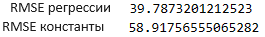